<a href="https://colab.research.google.com/github/AbbassiMomtez/D-tection-d-motions/blob/main/Projet_2_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print("Version de TensorFlow :", tf.__version__)
print("GPU disponible :", tf.config.list_physical_devices('GPU'))


Version de TensorFlow : 2.18.0
GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
# Étape 1 : Import des bibliothèques
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:00<00:00, 245MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [7]:
# Étape 2 : Chemins des données
data_dir_train = '/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train'
data_dir_test = '/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test'

Visualisation des images d'entraînement


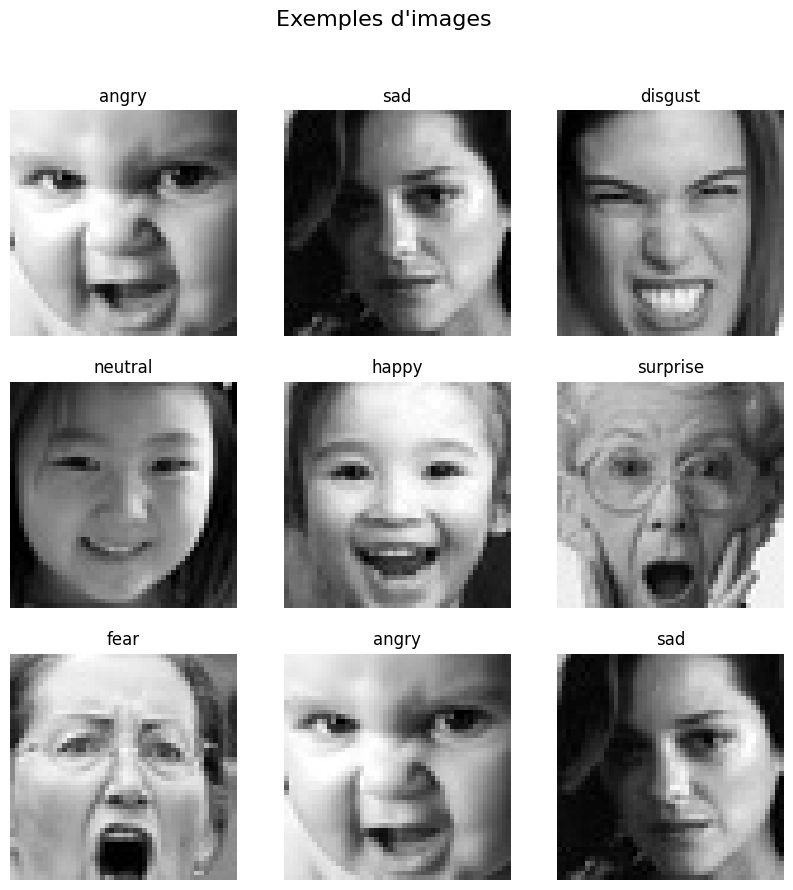

In [32]:
# Étape 3 : Visualisation d'exemples d'images
def visualize_images(data_dir, n_images=9):
    """Affiche des exemples d'images avec leurs étiquettes."""
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle("Exemples d'images", fontsize=16)
    for i, ax in enumerate(axes.flat):
        class_dir = os.listdir(data_dir)[i % len(os.listdir(data_dir))]
        img_path = os.path.join(data_dir, class_dir, os.listdir(os.path.join(data_dir, class_dir))[0])
        img = plt.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.set_title(class_dir)
        ax.axis('off')
    plt.show()

print("Visualisation des images d'entraînement")
visualize_images(data_dir_train)

In [47]:
# Étape 4 : Prétraitement et augmentation des données
img_size = (48, 48)  # Taille des images (FER-2013 utilise des images 48x48 en niveaux de gris)
batch_size = 64

data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Moins de rotation
    width_shift_range=0.1,  # Moins de décalage horizontal
    height_shift_range=0.1,  # Moins de décalage vertical
    horizontal_flip=True  # Garder le flip horizontal
)

data_gen_test = ImageDataGenerator(rescale=1.0/255.0)  # Normalisation uniquement

In [48]:
train_data = data_gen_train.flow_from_directory(
    data_dir_train,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)

test_data = data_gen_test.flow_from_directory(
    data_dir_test,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


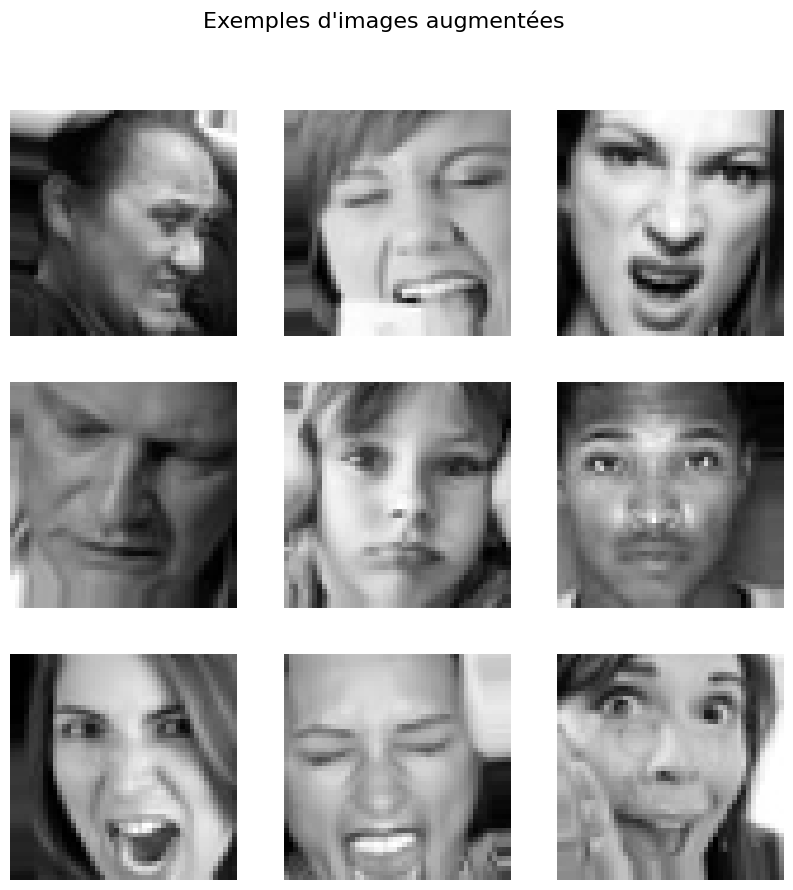

In [49]:
# Visualisation d'images augmentées
augmented_images, _ = next(train_data)
plt.figure(figsize=(10, 10))
plt.suptitle("Exemples d'images augmentées", fontsize=16)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [50]:
# Étape 5 : # Construction du modèle CNN amélioré
model = Sequential([
    Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(512, (3, 3), activation='relu'),  # Nouvelle couche
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer='l2'), # Augmentation des neurones et ajout de régularisation L2
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax') # 7 classes d'émotions
])

# Changement de l'optimiseur pour un meilleur ajustement
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 44, 44, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 44, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,822,983 (6.95 MB)

 Trainable params: 1,820,039 (6.94 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [51]:
# Étape 6 : Définition des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [52]:
# Étape 7 : Entraînement du modèle
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Réduction du learning rate si la validation loss stagne
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=100,  # Augmenter les epochs
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.1734 - loss: 7.8976 - val_accuracy: 0.2561 - val_loss: 6.5605 - learning_rate: 1.0000e-04
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.2120 - loss: 6.7655 - val_accuracy: 0.3206 - val_loss: 5.5942 - learning_rate: 1.0000e-04
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.2367 - loss: 5.9624 - val_accuracy: 0.3540 - val_loss: 4.9242 - learning_rate: 1.0000e-04
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.2596 - loss: 5.2215 - val_accuracy: 0.3624 - val_loss: 4.3772 - learning_rate: 1.0000e-04
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.2858 - loss: 4.6020 - val_accuracy: 0.3759 - val_loss: 3.9137 - learning_rate: 1.0000e-04
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.3163 - loss: 4.0409 - val_accuracy: 0.3848 - val_loss: 3.5051 - learning_rate: 1.0000e-04
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - a

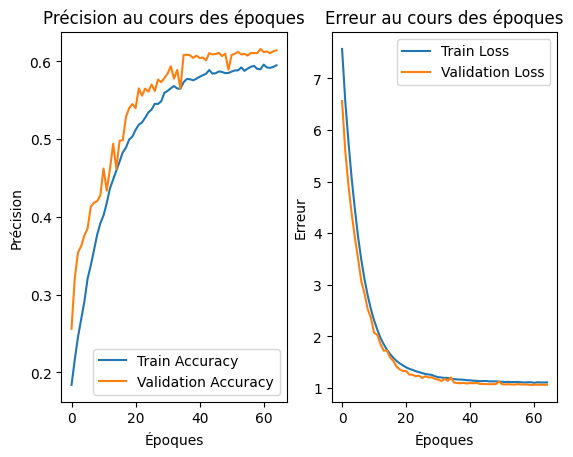

In [53]:
# Étape 8 : Visualisation des performances
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Précision au cours des époques')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Erreur au cours des époques')
plt.xlabel('Époques')
plt.ylabel('Erreur')
plt.legend()

plt.show()

In [54]:
# Étape 9 : Évaluation sur les données de test
loss, accuracy = model.evaluate(test_data)
print(f"\nÉvaluation finale :\n - Précision : {accuracy*100:.2f}%\n - Perte : {loss:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6208 - loss: 1.0497

Évaluation finale :
 - Précision : 61.60%
 - Perte : 1.0580


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


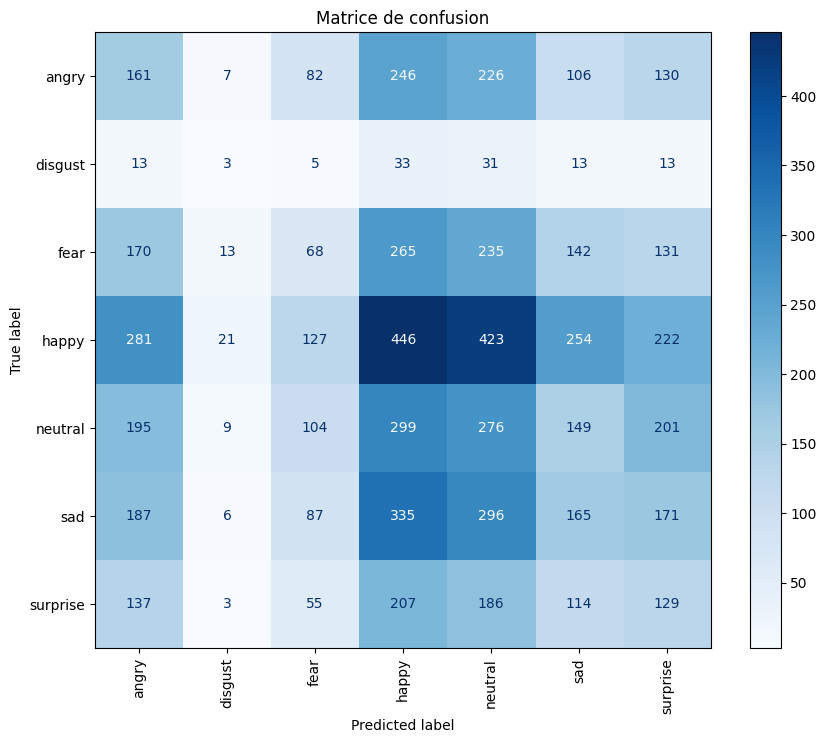

In [55]:
# Étape 10 : Matrice de confusion et visualisation des prédictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_data.class_indices.keys())

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues', xticks_rotation='vertical', ax=plt.gca())
plt.title('Matrice de confusion')
plt.show()

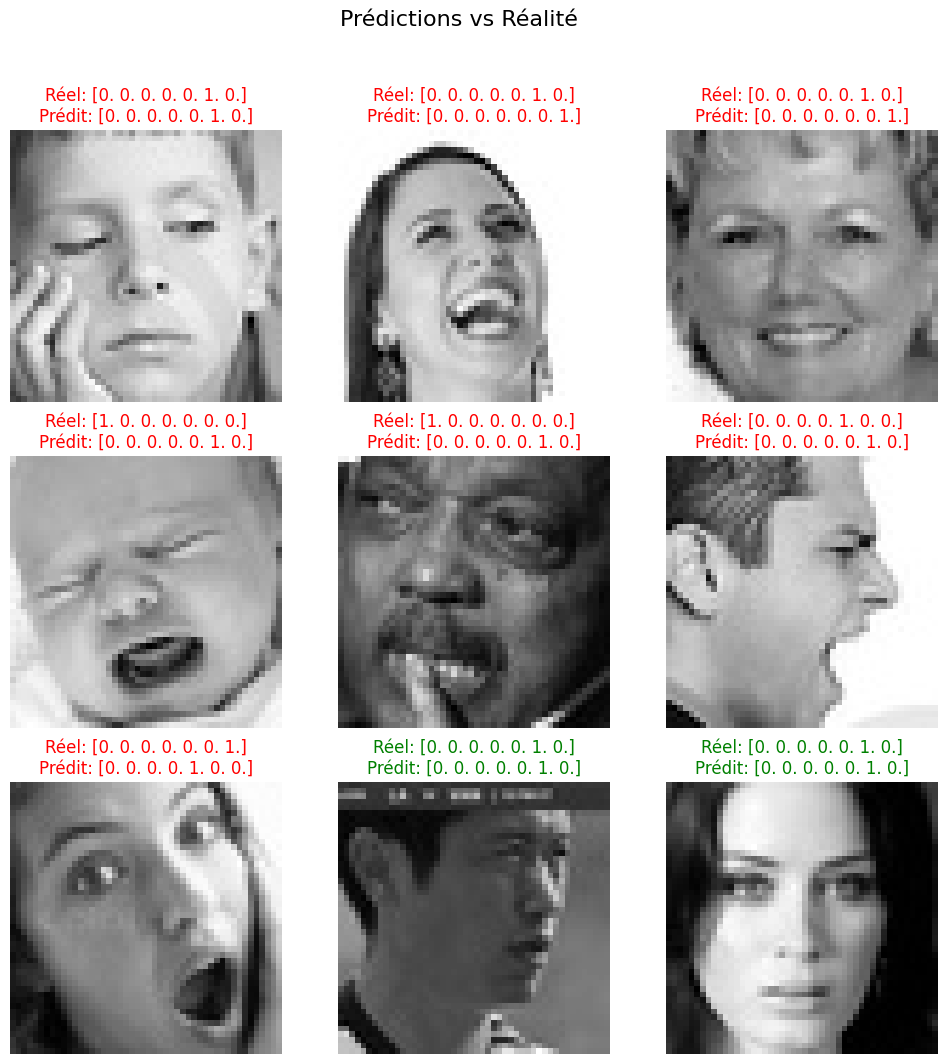

In [62]:
# Visualisation d'images avec prédictions et étiquettes réelles
def plot_predictions(test_data, y_pred_classes, n_images=9):
    """Affiche des images avec leurs étiquettes prédites et réelles."""
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Prédictions vs Réalité', fontsize=16)

    images, labels = next(test_data)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        true_label = labels[i].argmax()
        predicted_label = y_pred_classes[i]
        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(f"Réel: {labels[true_label]}\nPrédit: {labels[predicted_label]}", color=color)
        ax.axis('off')
    plt.show()

plot_predictions(test_data, y_pred_classes)

In [63]:
!pip install Gradio

In [64]:
# Étape 11 : Déploiement avec Gradio
import gradio as gr # Import the gradio module and alias it as 'gr'

def emotion_recognition(image):
    """Prend une image en entrée, détecte les visages et prédit les émotions."""
    # Conversion en niveaux de gris et redimensionnement
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Gradio fournit des images au format RGB
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(48, 48))

    results = []
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48)) / 255.0
        face = np.expand_dims(face, axis=-1)
        face = np.expand_dims(face, axis=0)
        prediction = model.predict(face)
        emotion_label = labels[np.argmax(prediction)]
        results.append((emotion_label, (x, y, w, h)))

    for emotion_label, (x, y, w, h) in results:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image

iface = gr.Interface(
    fn=emotion_recognition,
    inputs=gr.Image(type="numpy"),  # Gradio utilise le format numpy pour les images
    outputs=gr.Image(type="numpy"),
    title="Détection d'Émotions avec CNN",
    description="Chargez une image pour détecter les émotions des visages présents."
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d9553e72a4ba2aab6c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
